In [1]:
import utils
import qiskit
import qiskit_aer
import numpy as np
from math import log
import qiskit.visualization
import matplotlib.pyplot as plt
from qiskit.circuit.library.standard_gates import RYGate

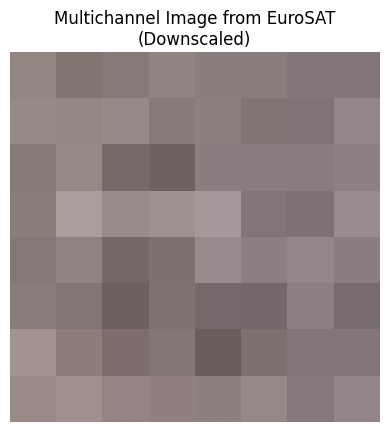

In [2]:
image = utils.plot_image('../images/residential_8by8by3.jpg', 'Multichannel Image from EuroSAT\n(Downscaled)')

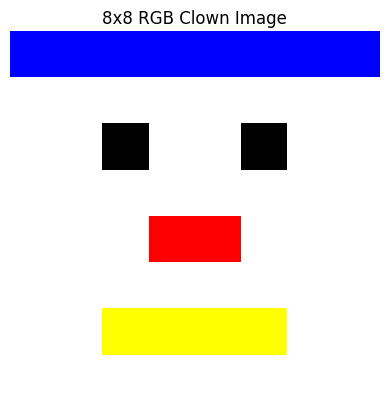

In [3]:
# Define a simple 8x8 RGB "clown" image
clown_image = np.zeros((8, 8, 3), dtype=np.uint8)

# Colors (R, G, B)
WHITE = [255, 255, 255]
BLACK = [0, 0, 0]
RED = [255, 0, 0]
BLUE = [0, 0, 255]
YELLOW = [255, 255, 0]

# Define clown's face (white background)
clown_image[:, :] = WHITE 

# Add clown's hat/hair (top row)
clown_image[0, :] = BLUE

# Add eyes (black)
clown_image[2, 2] = BLACK
clown_image[2, 5] = BLACK

# Add nose (red)
clown_image[4, 3:5] = RED

# Add mouth (yellow)
clown_image[6, 2:6] = YELLOW

# Display the clown image
plt.imshow(clown_image)
plt.title("8x8 RGB Clown Image")
plt.axis("off")
plt.show()

# Show the clown image array
image = clown_image


$$|I(\theta)\rangle=\frac 1{2^n+1}\sum_{i=0}^{2^{2n}-1}|C^i_{RGB_\alpha}\rangle\otimes|i\rangle$$

$$\vert C^{i}_{RGB_\alpha} \rangle = 
\cos \theta^{i}_{R} \vert 000 \rangle + \cos \theta^{i}_{G} \vert 001 \rangle + \cos \theta^{i}_{B} \vert 010 \rangle + \cos \theta_{\alpha} \vert 011 \rangle \\ 
+ \sin \theta^{i}_{R} \vert 100 \rangle + \sin \theta^{i}_{G} \vert 101 \rangle + \sin \theta^{i}_{B} \vert 110 \rangle + \sin \theta_{\alpha} \vert 111 \rangle
$$

In [4]:
def equal_superposition(circ: qiskit.QuantumCircuit, targets: int):
    for idx in range(targets): 
        circ.h(idx)
        
def iterate(circ: qiskit.QuantumCircuit, current_state: str, next_state: str):
    n = len(current_state)
    
    # Indices we must apply an X gate to go from current_state to next_state 
    #   - We reverse the state strings because we set the coordinates qubits in the circuit
    #       in descending order.
    x_targets = np.array([idx for idx in range(n) 
                          if current_state[::-1][idx] != next_state[::-1][idx]])

    # Example
    # 1110 -> 1111
    #   if we don't reverse the strings we get:
    #   x_targets = [3]
    #   thus we will apply the X gate on the fourth qubit.
    #   but this is not what we want, we should apply it to the first qubit.
    #   think little endian vs big endian
    
    if x_targets.size > 0:
        circ.x(x_targets)

def pixel_encoding(circ: qiskit.QuantumCircuit, control: list, target: int, intensity: float):
    # Making the C^nRY manually improves visualization
    cry = RYGate(2 * intensity).control(len(control))
    aux = np.append(control, target).tolist()
    circ.append(cry, aux)

In [5]:
def construct_mcrqi(circ: qiskit.QuantumCircuit, control: list, 
                   targets: list, image: np.array):
    num_qubits = circ.num_qubits
    coord_qubits = num_qubits - 3
    
    equal_superposition(circ, coord_qubits)
    circ.barrier()
    for channel_idx, img in enumerate(image.T): # .T to loop through the channels.
        flat_img = img.flatten() # flatten the image to 1-D
        flat_img = np.interp(flat_img, (0, 255), (0, np.pi/2))
                   
        for pixel_idx, pixel_value in enumerate(flat_img):            
            state = '{0:0{1}b}'.format(pixel_idx - 1, coord_qubits) 
            next_state = '{0:0{1}b}'.format(pixel_idx, coord_qubits)
            
            if pixel_idx > 0:
                iterate(circ, state, next_state)
            
            pixel_encoding(circ, control, coord_qubits + channel_idx, pixel_value)
            circ.barrier()
        
        # We reset the index for the next channel encoding
        if channel_idx < 2:
            iterate(circ, '{0:0{1}b}'.format(len(flat_img)-1, coord_qubits), 
                        '{0:0{1}b}'.format(0, coord_qubits))
        
        circ.barrier()
    
    circ.swap(-1, -3)
    circ.barrier()
    
    to_measure = [*range(num_qubits)]
    circ.measure(to_measure, to_measure)

In [6]:
flat_ang_rep = utils.get_angle_representation(image,
                                                min_val=0,
                                                max_val=255)
n = int(log(image.shape[0], 2))

qcord_register = qiskit.QuantumRegister(2 * n, 'Cord')
qcolor_register = qiskit.QuantumRegister(3, 'RGB')
creg = qiskit.ClassicalRegister(2 * n + 3, 'bits')

In [7]:
mcrqi_circ = qiskit.QuantumCircuit(qcord_register, qcolor_register, creg)
construct_mcrqi(mcrqi_circ, list(qcord_register), list(qcolor_register), image)

/Users/uribagi/Documents/PhD/CVC/quantum-representations-of-classical-data/qrep-env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/uribagi/Documents/PhD/CVC/quantum-representations-of-classical-data/qrep-env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/uribagi/Documents/PhD/CVC/quantum-representations-of-classical-data/qrep-env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/uribagi/Documents/PhD/CVC/quantum-representations-of-classical-data/qrep-env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


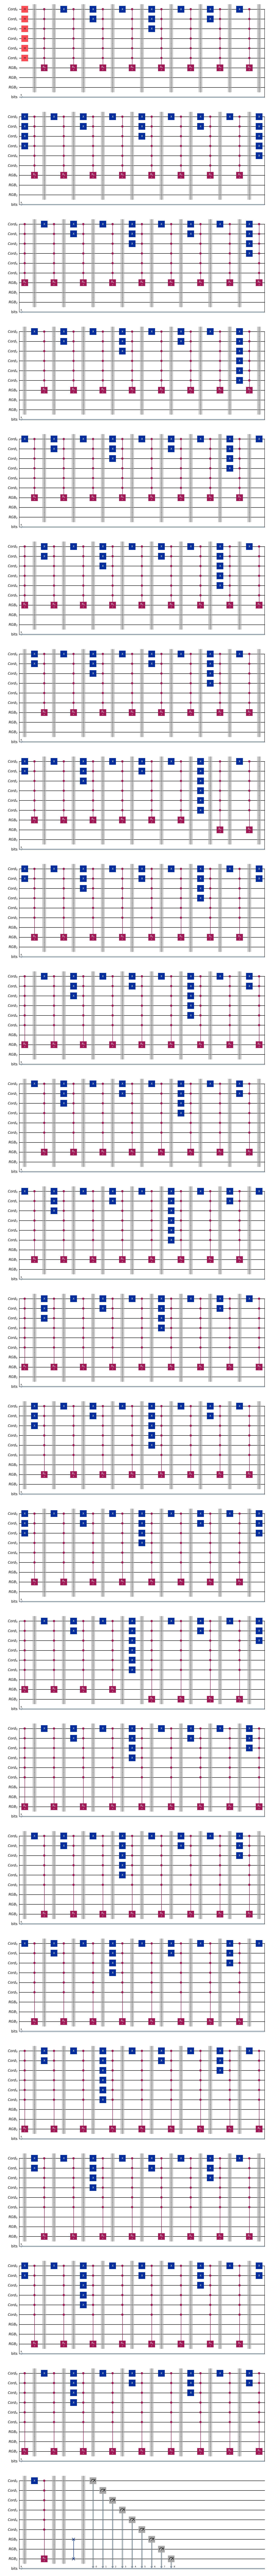

In [8]:
mcrqi_circ.draw(output='mpl')

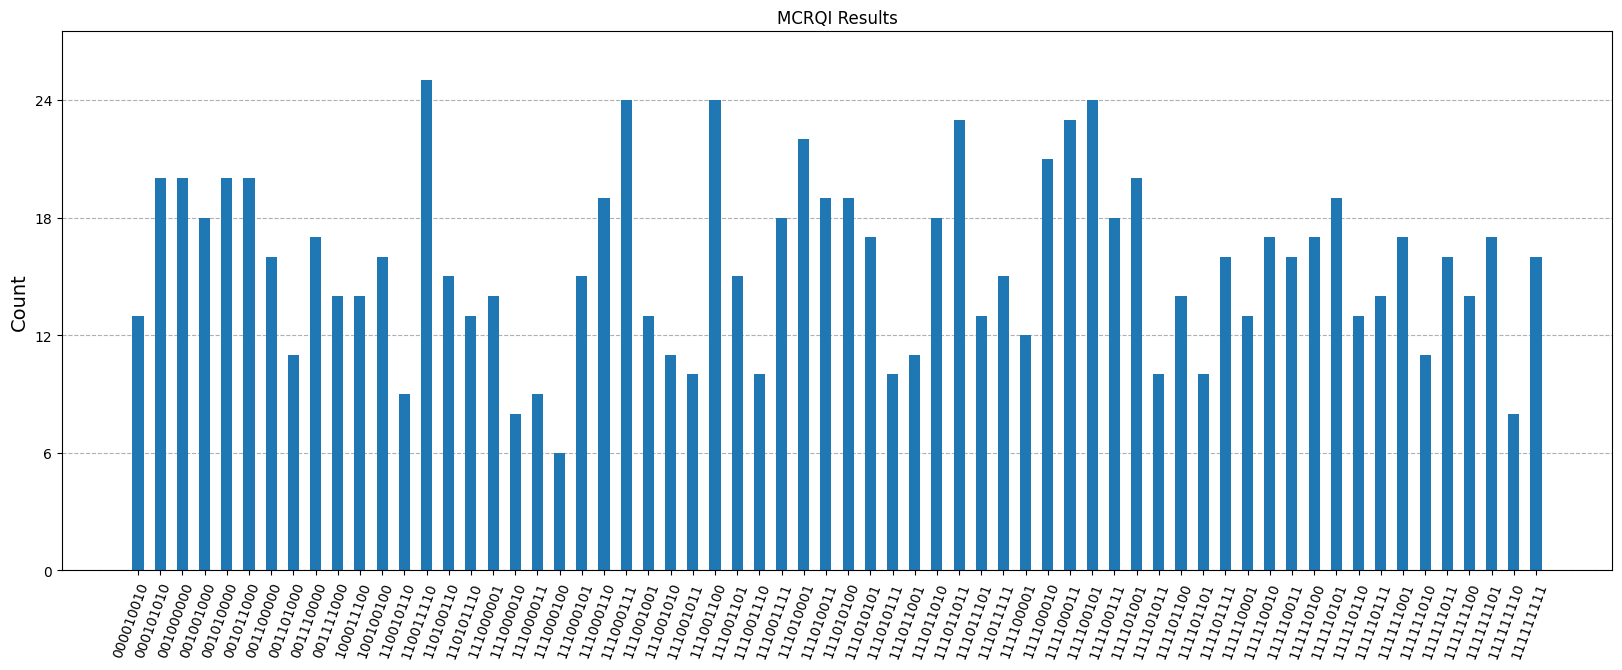

In [9]:
simulator = qiskit_aer.AerSimulator()
circuit = qiskit.transpile(mcrqi_circ, simulator)
shots = 1000
result = simulator.run(circuit, shots=shots).result()
counts = result.get_counts(circuit)
qiskit.visualization.plot_histogram(counts, figsize=(20, 7), title="MCRQI Results", bar_labels=False)

In [10]:
def reconstruct_rgb(image, counts):
    output_ims = []
    for layer_num, input_im in enumerate(image.T):
        input_im = input_im.flatten()
        nums = []
        for iter in range(len(input_im)): # every pixel iteration
            flag = 0
            num = []
            for item in counts.items():
                if int(item[0][3:], 2)==iter: # compare coordinate to pixel position
                    num.append((int(item[0][layer_num], 2), item[1])) # add [color, counts]
            nums.append(num)
        #print("Counts matrix " + str(layer_num) + "\n", nums, "\n") # matrix with colors and probabilities
        for l, num in enumerate(nums):
            my_set = {x[0] for x in num} # every different color in pixel
            nums[l] = [(i,sum(x[1] for x in num if x[0] == i)) for i in my_set] # sum of same color values
        colors = []
        for num in nums:
            #print(num)
            if len(num)==2:
                if num[0][0] == 0: # color value compared to total value calculation
                    color = np.arccos((num[0][1]/(num[0][1]+num[1][1]))**(1/2))
                    colors.append(color)
                else:
                    color = np.arccos((num[1][1]/(num[0][1]+num[1][1]))**(1/2))
                    colors.append(color)
            else:
                if len(num) == 0:
                    colors.append(0)
                else:
                    if num[0][0] == 0:
                        colors.append(0)
                    else:
                        colors.append(np.pi/2)
        #print("Colors matrix " + str(layer_num) + "\n", colors, "\n")
        output_im = np.interp(colors, (0, np.pi/2), (0, 255)).astype(int)
        output_ims.append(output_im.reshape(image[:,:,0].shape))
    return np.array(output_ims).T

output_ims = np.fliplr(reconstruct_rgb(image, counts))

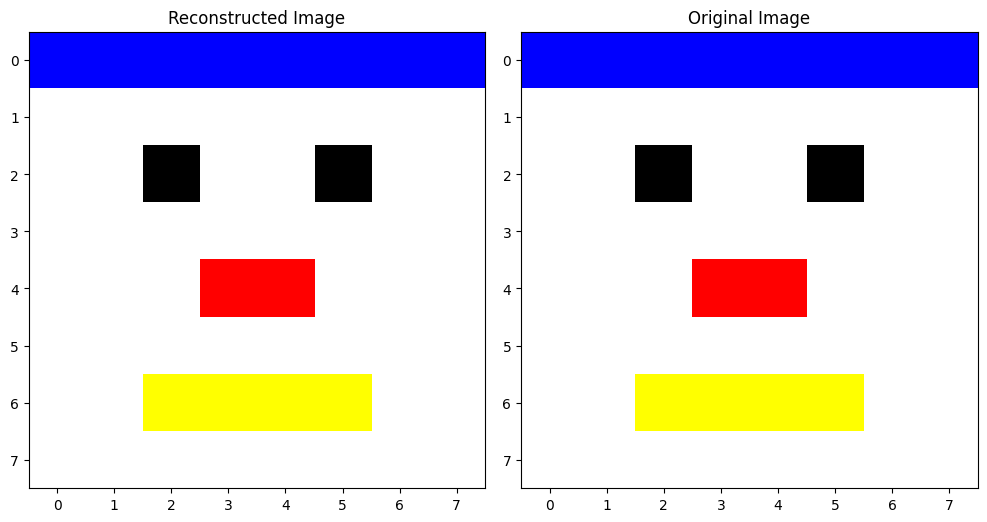

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(output_ims)
axs[0].set_title('Reconstructed Image')
axs[1].imshow(image)
axs[1].set_title('Original Image')

plt.tight_layout()